# 文本分类器(torchtext处理数据)
参考：[Torchtext 详细介绍 Part.1](https://zhuanlan.zhihu.com/p/37223078) , [github](https://github.com/keitakurita/practical-torchtext/blob/master/Lesson%201%20intro%20to%20torchtext%20with%20text%20classification.ipynb)
, [手把手教你用torchtext处理文本数据](https://cloud.tencent.com/developer/article/1168890)

In [46]:
import os
import re
import spacy
import torch
import torchtext
import numpy as np
import pandas as pd

## 1. 加载数据

In [47]:
data_root = os.path.join('../..', 'data','text')         # 设置数据的根目录
data_list = ['train', 'val', 'test']                     # 设置train,val,test路径
train_csv, val_csv, test_csv = map(lambda x:os.path.join(data_root, x+'.csv'), data_list)

数据如下，“评论文本”与其对应的标签“恶意，严重恶意，淫秽，威胁，侮辱和身份仇恨”，该数据集可以训练一个**文本分类器**

In [48]:
pd.read_csv(train_csv).head(2)                          # 显示训练集数据 
# pd.read_csv(val_csv).head(2)                          # 验证集与训练集的数据类型一致

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


In [49]:
pd.read_csv(test_csv).head(2)                           # 显示测试集数据 

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...


## 2.  声明Field对象定义数据预处理的pipline

### 2.1 定义tokenizer函数
进行数据清理

In [50]:
NLP = spacy.load('en')               # 导入英语模型
MAX_CHARS = 20000
def tokenizer(comment):         
    """
        func: 数据清洗及预处理，并返回token标记(字母与数字)
        comment：传入需要处理的文本字符串(str)
    """
    comment = re.sub(r'[\*\"“”\n\.\+\-\/\=\(\)\!;\\]', " ", str(comment))   # 滤除无用的字符串
    comment = re.sub(r'\s+', ' ', comment)               # 将多个空格合并为一个空格
    comment = re.sub(r'\!+', '!', comment)               # 将多个 ‘!’ 合并为一个
    comment = re.sub(r'\,+', ',', comment)               # 同上
    comment = re.sub(r'\?+', '?', comment)               # 同上
    
    if len(comment) > MAX_CHARS:                         # 如果数据过长就截断
        comment = comment[:MAX_CHARS] 
    # 仅返回字符和数字，滤除标点符号
    return [token.text for token in NLP.tokenizer(comment) if not token.is_space  and not token.is_punct]

In [51]:
# 测试tokenizer函数
test_doc = 'abc .... hahah,,, ..?? abc def class “ ” printf sub!! @  :  (\) fdf / 233((()))'
test_token = tokenizer(test_doc)
test_token

['abc', 'hahah', 'abc', 'def', 'class', 'printf', 'sub', 'fdf', '233']

### 2.2 定义Field对象
声明数据预处理的pipline

如果数据是文本段落，需设置`sequential=True`及`use_vocab=True`，如果处理的数据已经是数字，那将这两个标志设为False即可，`batch_first=True`将batch放在第一维，sequence放到第二维

更多参数参考：[官方注释](https://github.com/pytorch/text/blob/c839a7934930819be7e240ea972e4d600966afdc/torchtext/data/field.py#L61) 或 [blog：Torchtext指南 （侧重于NMT）](http://www.cnblogs.com/helloeboy/p/9882467.html)

In [52]:
from torchtext.data import Field

TEXT = Field(sequential=True, tokenize=tokenizer, lower=True, use_vocab=True, batch_first=True)
LABEL = Field(sequential=False, use_vocab=False, batch_first=True)

## 3. 构建数据集
### 3.1数据预处理
根据Field的声明来处理数据
csv数据一共8列，数据处理时必须按照列的顺序，传入`[(name, field), ]`列表作为fields的参数，没有使用的列使用`None`来声明，如`('id', None)`，其他的列按照定义好的Field类来处理相应的类型

In [53]:
%%time
from torchtext.data import TabularDataset

train_val_fields = [('id', None),       ('comment_text', TEXT),
                    ('toxic', LABEL),   ('severe_toxic', LABEL),
                    ('obscene', LABEL), ('threat', LABEL),
                    ('insult', LABEL),   ('identity_hate', LABEL)]
train_dataset, val_dataset = TabularDataset.splits(      # 同时处理多个数据集，用splits
    path = data_root,                                    # 数据所在的目录
    train = 'train.csv', validation = 'val.csv',
    format = 'csv',                                      # 指定处理文件格式
    skip_header = True,                                  # 如果csv有表头，则设置该参数，跳过表头
    fields = train_val_fields)

Wall time: 120 ms


测试数据没有标签所以处理方法与训练集和验证集不同

In [54]:
%%time
test_fields = [('id', None), ('comment_text', TEXT)]
test_dataset = TabularDataset(                           # 只处理一个数据集
    path = os.path.join(data_root, 'test.csv'),
    format = 'csv',
    skip_header = True,
    fields = test_fields)

Wall time: 47.1 ms


数据集大多和列表一样可以使用**索引**的方式来访问得到某个样本，如`train_dataset[0]`，但每个样本数据都是**字典**形式来存储，使用`sample.comment_text`来访问，其中comment_text是数据集某一列的**表头**

In [55]:
sample = train_dataset[0]             # 取出第一个数据
sample

In [56]:
sample.__dict__.keys()                # 第一个数据以字典的形式存储 

dict_keys(['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

In [57]:
print('1.文本数据：', sample.comment_text[:7])       # 每个样本可以使用字典的形式来访问
print('2.标签数据：',sample.toxic)

1.文本数据： ['explanation', 'why', 'the', 'edits', 'made', 'under', 'my']
2.标签数据： 0


### 3.2 根据训练集来建立词典
`stoi`属性返回{word:index,...}形式的**字典**(collections.defaultdict)，`itos`属性返回[word,...]形式的**列表**
可以使用`max_size`和`min_freq`来表示词汇表(字典)中有多少单词和单词最少频率，为出现在词汇表的单词转换为`<unk>`

In [58]:
%%time
TEXT.build_vocab(train_dataset) 

Wall time: 1 ms


In [59]:
TEXT.vocab.freqs.most_common(5)        # freqs是collections.Counter类型，统计出现频率高的词

[('the', 80), ('to', 41), ('you', 38), ('i', 32), ('of', 30)]

In [60]:
type(TEXT.vocab.stoi)

collections.defaultdict

<center>torchtext读取数据的几个类</center>

|类|描述|使用场景
|-|-|-|
|TabularDataset          |处理的文件类型有csv/tsv、json及python的dict |每一条文本都有一个(或多个)标签的问题，如文本分类|
|LanguageModelingDataset |以text文件的路径为输入                      |语言模型|
|TranslationDataset      |以每种语言文件的路径或扩展名为输入，例英语文件是"hoge.en"，法语文件是"hoge,fr"，输入为path="hoge", exts={"en", "fr"}|机器翻译|
|SequenceTaggingDataset  |输入是由tabs分割的输入序列和输出序列的文件路径|序列标注|

## 4. 创建迭代器
上述步骤已经将数据读入到内存，在该步骤中将数据划分为批次，方便送入网络

设置`sort_within_batch=False`，按照`sort_key`对每个批次内进行降序排列，用于对序列进行padding，将序列变为等长，这里的`sort_key = lambda token:len(token.comment_text)`语句表示根据单词长度来进行padding

In [61]:
from torchtext.data import Iterator, BucketIterator
train_iter, val_iter = BucketIterator.splits((train_dataset, val_dataset),  # 传入数据集
        batch_sizes = (25,25),                     # (train_batch, val_batch)
        device = -1,                               # CPU:-1 GPU:指定GPU编号，从0开始
        sort_key = lambda token:len(token.comment_text),   # 依据文本的长度对数据进行分组
        sort_within_batch = False,
        repeat = False)                            # 设置为False，可以对迭代器进行再次包装
                                            
test_iter = Iterator(test_dataset, batch_size=25, device=-1,
                    sort=False, sort_within_batch=False, repeat=False) 

In [62]:
# 读取批次化的数据
sample_batch = next(iter(train_iter))
sample_batch


[torchtext.data.batch.Batch of size 25]
	[.comment_text]:[torch.LongTensor of size 25x503]
	[.toxic]:[torch.LongTensor of size 25]
	[.severe_toxic]:[torch.LongTensor of size 25]
	[.obscene]:[torch.LongTensor of size 25]
	[.threat]:[torch.LongTensor of size 25]
	[.insult]:[torch.LongTensor of size 25]
	[.identity_hate]:[torch.LongTensor of size 25]

In [63]:
sample_batch.__dict__.keys()

dict_keys(['batch_size', 'dataset', 'train', 'fields', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

In [64]:
sample_batch.comment_text         # 文本数据

tensor([[600,  12,   2,  ...,   1,   1,   1],
        [101,   3, 172,  ...,   1,   1,   1],
        [200,  48, 198,  ...,   1,   1,   1],
        ...,
        [368,  35, 495,  ...,   1,   1,   1],
        [  2, 205, 254,  ...,   1,   1,   1],
        [313,  15,   7,  ...,   1,   1,   1]])

In [65]:
sample_batch.toxic               # 标签数据 

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0])

#### 注意这种自定义数据类型使代码重用很难，当csv数据的列名(表头)改变时，代码也要改变

## 5. 包装迭代器
在上述数据集中有多个标签，而迭代器返回一个文本向量和多个标签向量，但训练模型时标签一般都是一个向量，所以需要将上述迭代器产生的结果进行包装，最终得到(x,y)形式的样本和标签对

In [66]:
class BatchWrapper(object):
    def __init__(self, data_iter, x_var, y_vars):
        """
        func: 对数据迭代器进行包装，返回(x,y)形式的批次形式
        data_iter: 数据迭代器
        x_var: 作为数据x的变量名称(列表)
        y_vars：作为标签y的变量名称(列表)
        """
        self.data_iter, self.x_var, self.y_vars = data_iter, x_var, y_vars
    def __iter__(self):
        for batch in self.data_iter:
            x = getattr(batch, self.x_var)           # 提取数据的x_var属性，这里对应comment_text
            
            if self.y_vars is not None:              # 把y拼接为一个向量
                # (N,) => (N,1) 再进行拼接
                temp = [getattr(batch, attr).unsqueeze(1) for attr in self.y_vars]
                y = torch.cat(temp, dim=1).float()   # 并转换类型，标签需要float类型
            else:
                y = torch.zeros((1))
            yield (x, y)
            
    def __len__(self):
        return len(self.data_iter)

In [67]:
x_var = 'comment_text'
y_vars = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_loader = BatchWrapper(train_iter, x_var, y_vars)
val_loader   = BatchWrapper(val_iter, x_var, y_vars)
test_loader  = BatchWrapper(test_iter, x_var, None)

In [68]:
x_batch, y_batch = next(train_loader.__iter__())
print('1.x的tensor:', x_batch.shape)
print('2.y的tensor:', y_batch.shape)

1.x的tensor: torch.Size([25, 503])
2.y的tensor: torch.Size([25, 6])


## 6. 训练文本分类器

In [69]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

### 6.1 定义文本分类器

In [70]:
class LSTMBaseline(nn.Module):
    def __init__(self, embed_size, hidden_size, num_linear=0):
        """
        func: 定义简单的LSTM模型进行文本分类
        embed_size：嵌入的维度大小
        hidden_size：lstm隐藏状态的大小
        num_linear：全连接的层数
        """
        super().__init__()
        # 词汇表的大小是len(TEXT.vocab)
        self.embedding = nn.Embedding(len(TEXT.vocab), embed_size)      # (N,seq,embed_size)
        self.encoder = nn.LSTM(embed_size, hidden_size, num_layers=2, batch_first=True, dropout=0.1)
        self.linear_layers = []                       # 中间全连接层的列表 
        # 将中间层添加到模型中
        for _ in range(num_linear):
            self.linear_layers.append(nn.Linear(hidden_size, hidden_size)) 
        self.linear_layers = nn.ModuleList(self.linear_layers)         # 转换为模型层
        # 输出层
        self.predictor = nn.Linear(hidden_size, 6)     # 6个标签，所以输出维度为6
   
    def forward(self, seq):
        embedded_out = self.embedding(seq)             # (N,seq) => (N,seq,embed_size)
        lstm_out, lsmt_hidden = self.encoder(embedded_out)     # (N,seq,hidden)
        feature = lstm_out[:,-1,:]                     # 取最后step的输出 (N,hidden) 
        for layer in self.linear_layers:               # (N,hidden)
            feature = layer(feature)
        predicts = self.predictor(feature)             # (N,6) 未经过log_softmax处理
        return predicts

### 6.2 训练文本分类器

In [71]:
embedding_size = 128
hidden_size = 500
lstm_model = LSTMBaseline(embedding_size, hidden_size)      # 定义模型
criterion = nn.BCEWithLogitsLoss()                          # 使用二分类损失
# criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=1e-3) 

In [72]:
def train(model, train_loader, val_loader, epochs=1):
    """
    func：训练模型
    train_data：训练数据集
    val_data：验证集
    epochs：训练epochs
    """
    pltLoss = []
    running_loss = 0
    GPU = lambda x:x.to(device)                        # 优先使用GPU
    model.to(device)
    for epoch in range(1, epochs+1):
        model.train()                                  # 训练模式
        for data in train_loader:
            x, y = data
            x, y = map(GPU, [x, y])
            preds = model(x)
            prob = 1 /(1+torch.exp(-preds.data) )

            loss = criterion(preds, y)
            print_loss = loss.item()                   # 获取loss数据            
            optimizer.zero_grad()                      # 更新参数
            loss.backward()
            optimizer.step()
            
            running_loss += print_loss * x.shape[0]

            break
        epoch_loss = running_loss / len(train_loader)           # 计算epoch的损失
        running_loss = 0                                        # 切记epoch完成后清零
        pltLoss.append(epoch_loss)
        
        # 计算验证集上的误差
        val_loss = 0
        model.eval()                                            # 模型进入测试模型
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = map(GPU, [x_val, y_val])         # 数据放到GPU上
                preds = model(x_val)       
                loss = criterion(preds, y_val)
                val_loss += loss.item() * x_val.shape[0]
            epoch_val_loss = val_loss / len(val_loader)
        print('Epoch: {:<3} Train Loss: {:<8.4f} Val Loss: {:<7.4f}'.format(
            epoch, epoch_loss, epoch_val_loss))
    return model, pltLoss          

In [73]:
%%time
# 开始训练模型
epochs = 10
model, plt_loss= train(lstm_model, train_loader, val_loader, epochs=epochs)

D:\ProgramData\Anaconda3\lib\site-packages\torchtext\data\field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


Epoch: 1   Train Loss: 17.4492  Val Loss: 14.5220
Epoch: 2   Train Loss: 14.4247  Val Loss: 9.6551 
Epoch: 3   Train Loss: 9.2733   Val Loss: 6.1040 
Epoch: 4   Train Loss: 5.2720   Val Loss: 5.6771 
Epoch: 5   Train Loss: 4.4929   Val Loss: 5.6469 
Epoch: 6   Train Loss: 3.9501   Val Loss: 5.4768 
Epoch: 7   Train Loss: 3.8724   Val Loss: 5.5438 
Epoch: 8   Train Loss: 3.8651   Val Loss: 5.5877 
Epoch: 9   Train Loss: 3.8549   Val Loss: 5.5679 
Epoch: 10  Train Loss: 3.8055   Val Loss: 5.5063 
Wall time: 12.9 s


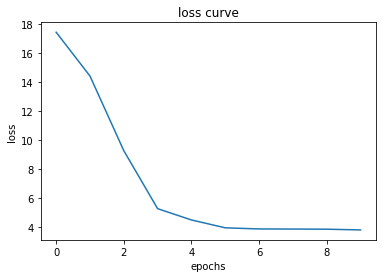

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('loss curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(plt_loss)

## 7. 评估模型性能
在上述模型中，相当于进行了6个二分类，而网络输出的是未进行归一化的分数，所以为了得到概率表示，可以使用sigmoid处理分数向量，得到各自的概率，可以把每一类比作一个神经元，所以使用sigmoid来计算概率

In [81]:
test_preds = []
model.eval()
model.cpu()
with torch.no_grad():
    for x, y in test_loader:
        preds = model(x)
        preds = preds.data.numpy()                  # 将数据转换为numpy格式
        probs = 1 / (1 + np.exp(-preds))            # sigmoid函数处理
        test_preds.append(probs)
test_preds = np.vstack(test_preds)

In [85]:
df = pd.read_csv(test_csv)
for i, col in enumerate(["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]):
    df[col] = test_preds[:, i]

In [87]:
df.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.141822,0.024757,0.028517,0.00154,0.014846,0.001408
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.141822,0.024757,0.028517,0.00154,0.014846,0.001408
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.141822,0.024757,0.028517,0.00154,0.014846,0.001408


### 总结：

torchtext处理数据的步骤为：
1. 定义Field类，声明数据预处理的方式
2. 使用TabularDataset等数据集类按照Field的要求处理数据
3. 使用BucketIterator或Iteration迭代器将数据集分成批次数据(此时数据就可以输入到网络了)
4. 可以对迭代器再次进行包装，如这里的多标签向量进行合并得到一个表情向量，最终得到`(x,y)`数据和标签对

spacy自然语言处理库可以进行分词、实体识别、和依赖关系划分等功能，并且速度很快